# Prosper Loan Exploration
## by Vincent Hamel

## Investigation Overview

> In this investigation we wanted to study a loan characteristics and find what is driving a higher APR and the loan status.

## Dataset Overview

> There are 77543 loans in the dataset and 13 variables were kept for the purpose of this investigation. All other variables were removed or cleaned due to missing or untidy data.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
loan = pd.read_csv('prosperLoanData.csv')

In [4]:
# Keep the variables of interest
filtered = ['Term', 'LoanStatus', 'BorrowerAPR', 'ProsperRating (Alpha)','ProsperScore', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'IncomeVerifiable', 'LoanOriginalAmount']
loan_clean = loan[filtered]

In [5]:
# Remove null data
loan_clean = loan_clean.dropna(how='any')
loan_clean.shape[0]

77543

In [6]:
# Rename ProsperRating (Alpha) to ProsperRating
loan_clean = loan_clean.rename(columns={'ProsperRating (Alpha)':'ProsperRating'})

In [7]:
# Convert ProsperRating into ordered categorical types
ordinal_var_dict = ['AA','A','B','C','D','E','HR']
loan_clean['ProsperRating'] = loan_clean['ProsperRating'].astype('category', ordered = True,categories = ordinal_var_dict)

In [8]:
# Create a credit score column that averages the upper and lower range credit score data
loan_clean['CreditScoreAvg'] = loan_clean[['CreditScoreRangeUpper', 'CreditScoreRangeLower']].mean(axis=1)
loan_clean.drop(['CreditScoreRangeLower','CreditScoreRangeUpper'],axis=1,inplace=True)


In [9]:
# Remove non verifiable income
non_verifiable = loan_clean[loan_clean.IncomeVerifiable==False].index
loan_clean.drop(non_verifiable, inplace=True)

## Proportion of loan status

> We have kept the features of interest which are the completed, defaulted and charged off loans. The aim is to see the proportion of defaulted, charged off loans compared to the completed ones. Defaulted and charged off represent 3.8% and 19.3% respectively.

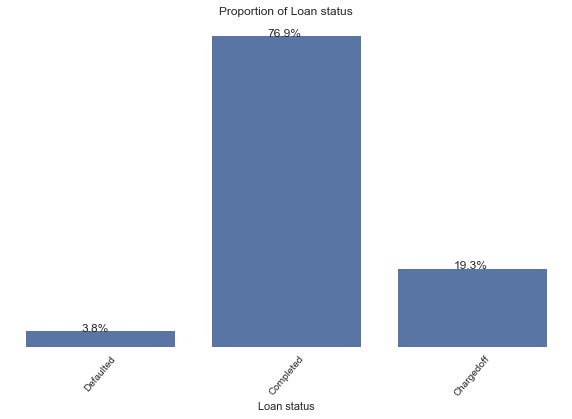

In [10]:
# Let's break this down in two parts: first the completed, defaulted and charged off loans. 
# This will also serve as a basis for our analysis.
# Then we will group together the past due loans by number of days.
loan_status_main = loan_clean[loan_clean['LoanStatus'].isin(['Completed','Defaulted','Chargedoff'])]
loan_status_past = loan_clean[loan_clean['LoanStatus'].isin(['Past Due (1-15 days)','Past Due (31-60 days)','Past Due (91-120 days)','Past Due (61-90 days)','Past Due (16-30 days)','Past Due (>120 days)'])]
# Proportion of loan status
plt.figure(figsize=(10,6))
base = sb.color_palette()[0]
ax = sb.countplot(data=loan_status_main, x='LoanStatus', color=base);
plt.xticks(rotation=50);

total = len(loan_status_main['LoanStatus'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)
ax.set(yticklabels=[]);
ax.set(ylabel="")
plt.title("Proportion of Loan status");
plt.xlabel("Loan status")
ax.grid(False)
ax.set_axis_bgcolor('white');

## Distribution of APR

> To analyse the distribution of APR we have created smaller bins. We can see while the majority of loans would have a 0.2 rate others get a higher rate of 0.35.

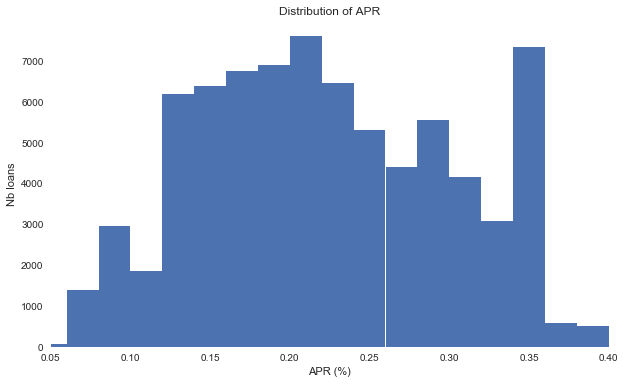

In [11]:
# Distribution of borrowers APR
plt.figure(figsize=(10,6))
bins = np.arange(0, loan_clean.BorrowerAPR.max()+0.02, 0.02)
plt.hist(data=loan_clean, x='BorrowerAPR', bins=bins)
ax = plt.gca()
ax.set_facecolor('white')
plt.grid (b=None)
plt.xlim(0.05, 0.40)
plt.xlabel("APR (%)")
plt.ylabel("Nb loans")
plt.title("Distribution of APR");

## Heatmap of quantitative variables

> The heatmap shows that the APR is highly correlated with the Prosper rating and the average credit score.

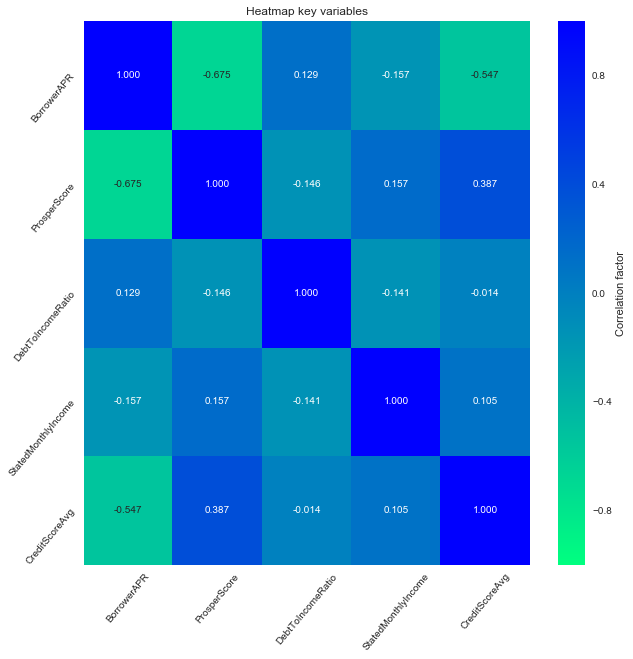

In [12]:
numeric_vars = ['BorrowerAPR', 'ProsperScore', 'DebtToIncomeRatio' , 'StatedMonthlyIncome', 'CreditScoreAvg']

# correlation plot
plt.figure(figsize = [10, 10])
ax = sb.heatmap(loan_clean[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'winter_r', center = 0, cbar_kws={'label': 'Correlation factor'})
ax.set_title("Heatmap key variables")
plt.xticks(rotation=50)
plt.yticks(rotation=50)
plt.show()


## Loan status depending on employment duration and loan amount

> This is to highlight that defaulted and charged off loans tend to be based on lower loan amounts and lower employment duration. 

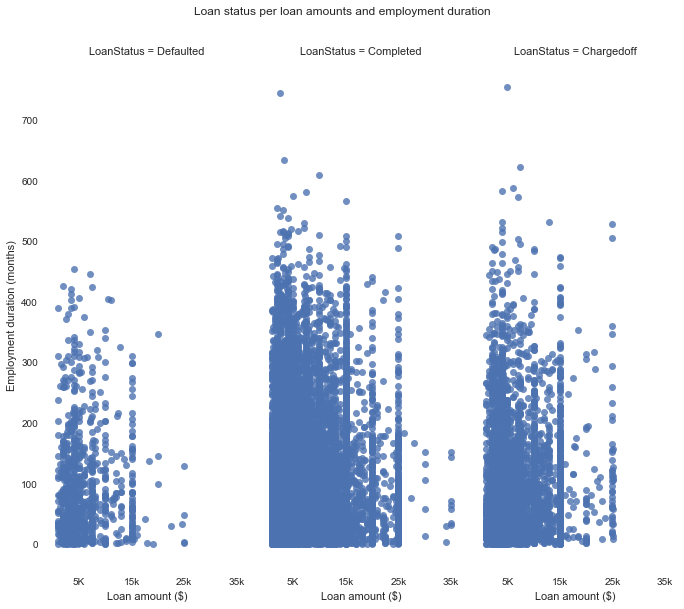

In [25]:
# Relationship loan amount and employment duration with the loan status
loan_breakdown = loan_clean[loan_clean['LoanStatus'].isin(['Defaulted','Chargedoff','Completed'])]
samples = loan_clean.sample(n=300)
g = sb.FacetGrid(data = loan_breakdown, col='LoanStatus', size=8, aspect=0.4)
g = g.map(sb.regplot, 'LoanOriginalAmount', 'EmploymentStatusDuration', x_jitter=1, fit_reg=False)
for i in range(3):
    g.axes[0,i].set_xlabel('Loan amount ($)')
    g.axes[0,i].set_facecolor('white')
    g.axes[0,i].grid (b=None)
g.axes[0,0].set_ylabel('Employment duration (months)')
g.fig.suptitle("Loan status per loan amounts and employment duration", y=1.05)
g.set(xticks=[5000, 15000, 25000, 35000], xticklabels=['5K', '15k', '25k', '35k']);